<a href="https://colab.research.google.com/github/tbottelbergs/cv_copy/blob/master/CV_V0.0.9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer vision Final project

# Version History

## V0.0.1 
* One-hot encoding (based on first class)
* Predictions based on softmax (no extra hidden layer of MobileNetV2)
* Optimizer='rmsprop', Loss='categorical_crossentropy'

## V0.0.2
* Added extra hidden layer of 1024 nodes
* Accuracy never rises above 74% (depends on which class is selected as first class)

## V0.0.3
* Added multi-label targets
* Changed output layer to 'sigmoid' activation function
* Changed the loss function to tf.keras.losses.CategoricalCrossentropy(from_logits=True)
* Changed the metric to categorical_accuracy

## V0.0.4
* Changed loss function to tf.nn.sigmoid_cross_entropy_with_logits
-> doesn't make things better

## V0.0.5
* Using TruePositives, TrueNegatives, FalsePositives, FalseNegatives, TopKCategoricalAccuracy(k=1) as metric
* Added fine tuning of last 55 layers of the base model

## V0.0.6
* Split training and test as was done for the VOC dataset
* Removed from_logits = True
* Switched to BinaryCrossentropy instead of CategoricalCrossentropy
* Used Adam optimiser

## V0.0.7
* Using learning rate LR = 1e-5

## V0.0.8
* Doubled the number of epochs to 20
* Rescaled the data to [-1,1] -> did not seem to have a positive effect

## V0.0.9
* Added Macro F1 as a metric

## V0.0.10
* Increased learning rate to 1e-4 for the first learning part

Fetch data

In [0]:
import os
from skimage import io
from skimage.transform import resize
import numpy as np
import random
import tensorflow as tf
from xml.dom import minidom
import matplotlib.pyplot as plt

In [2]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xf VOCtrainval_11-May-2009.tar --totals



--2020-05-23 05:40:01--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2009.tar’

VOCtrainval_11-May- 100%[===================>] 892.19M  12.2MB/s    in 75s     

2020-05-23 05:41:17 (11.9 MB/s) - ‘VOCtrainval_11-May-2009.tar’ saved [935534080/935534080]

Total bytes read: 935536640 (893MiB, 335MiB/s)


To keep in mind:
* In one image, multiple objects can appear (also of different classes)
* Every image has at least one object in it?

In [0]:
voc_root_folder = "/content/VOCdevkit/VOC2009"
trainImageNamesFile = os.path.join(voc_root_folder,'ImageSets','Main','train.txt')
valImageNamesFile = os.path.join(voc_root_folder,'ImageSets','Main','val.txt')
trainImageNames = np.loadtxt(trainImageNamesFile, dtype='str')
valImageNames = np.loadtxt(valImageNamesFile, dtype='str')

In [4]:
CLASSES = ['aeroplane','bicycle','bird','boat','bottle', 'bus','car','cat','chair','cow', 'diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
class_to_idx = dict((c, i) for i, c in enumerate(CLASSES))
idx_to_class = dict((i, c) for i, c in enumerate(CLASSES))
def one_hot_encode(clss):
  encoded = [0 for _ in range(len(CLASSES))]
  for cls in clss:
    encoded[class_to_idx[cls]] = 1
  return encoded
def one_hot_decode(encoded):
  clss = [idx_to_class[idx] for idx, val in enumerate(encoded) if val == 1]
  return clss
a = one_hot_encode(['bicycle', 'bus', 'chair'])
print(a)
print(one_hot_decode(a))

[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['bicycle', 'bus', 'chair']


In [0]:
image_folder = os.path.join(voc_root_folder, "JPEGImages")
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def createDataSet(imageNames):
  images = []
  targets = []
  for imageName in imageNames:
    xmlFile = os.path.join(voc_root_folder,'Annotations',imageName + '.xml')
    xml = minidom.parse(xmlFile)
    objectsXml = xml.getElementsByTagName('object')
    objects = []
    image = io.imread(os.path.join(image_folder,imageName + ".jpg"))
    image = (image/127.5) - 1
    image = resize(image, IMG_SHAPE)
    for objectXml in objectsXml:
      object = objectXml.getElementsByTagName('name')[0].firstChild.nodeValue
      if object not in objects:
        objects.append(object)
    #if(len(objects) == 1):
    targets.append(one_hot_encode(objects))
    images.append(image)
  return (images,targets)

In [0]:
trainImages, trainTargets = createDataSet(trainImageNames)
validationImages, validationTargets = createDataSet(valImageNames)

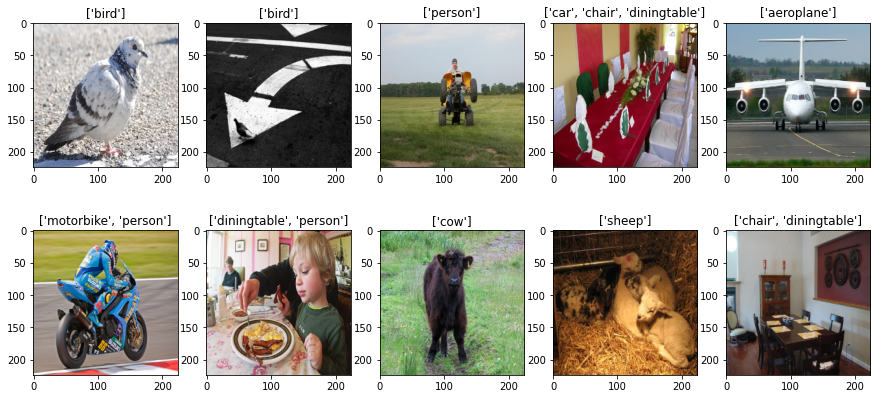

In [7]:
fig=plt.figure(figsize=(15, 7))
for i in range(1,6):
  idx = random.randint(0,len(trainImages))
  fig.add_subplot(2, 5, i)
  plt.imshow((trainImages[idx]+1)/2)
  plt.title(one_hot_decode(trainTargets[idx]))
for i in range(6,11):
  idx = random.randint(0,len(validationImages))
  fig.add_subplot(2, 5, i)
  plt.imshow((validationImages[idx]+1)/2)
  plt.title(one_hot_decode(validationTargets[idx]))

In [0]:
x_train = np.array(trainImages).astype('float32')
y_train = np.array(trainTargets)
x_val = np.array(validationImages).astype('float32')
y_val = np.array(validationTargets)

In [0]:
BATCH_SIZE = 100
train_batches = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
validation_batches = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

In [10]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
base_model.trainable = False

In [0]:
class MacroF1(tf.keras.metrics.Metric):

    def __init__(self, name='macro_f1', **kwargs):
      super(MacroF1, self).__init__(name=name, **kwargs)
      self.true_positives = self.add_weight(name='tp', shape=(20), initializer='zeros')
      self.false_positives = self.add_weight(name='fp', shape=(20), initializer='zeros')
      self.true_negatives = self.add_weight(name='tn', shape=(20), initializer='zeros')
      self.false_negatives = self.add_weight(name='fn', shape=(20), initializer='zeros')
      self.f1 = self.add_weight(name='f1', shape=(20), initializer='zeros')

    def update_state(self, y_true, y_pred):
      y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
      tp = tf.cast(tf.math.count_nonzero(y_pred * y_true, axis=0), tf.float32)
      fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y_true), axis=0), tf.float32)
      tn = tf.cast(tf.math.count_nonzero((1 - y_pred) * (1 - y_true), axis=0), tf.float32)
      fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y_true, axis=0), tf.float32)
      self.true_positives.assign_add(tp)
      self.false_positives.assign_add(fp)
      self.true_negatives.assign_add(tn)
      self.false_negatives.assign_add(fn)

    def result(self):
      f1 = 2*self.true_positives / (2*self.true_positives + self.false_negatives + self.false_positives + 1e-16)
      self.f1.assign(f1)
      macro_f1 = tf.reduce_mean(f1)
      return macro_f1

    def reset_states(self):
      # The state of the metric will be reset at the start of each epoch.
      self.true_positives.assign(np.zeros(20))
      self.false_positives.assign(np.zeros(20))
      self.true_negatives.assign(np.zeros(20))
      self.false_negatives.assign(np.zeros(20))
      self.f1.assign(np.zeros(20))

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
predictions = tf.keras.layers.Dense(20, activation='sigmoid')
LR = 1e-4
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
  predictions
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[MacroF1(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TopKCategoricalAccuracy(k=1)])

In [14]:
print(len(base_model.layers))

155


In [15]:
print(sum(sum(y_train)))
print(y_train.shape)

5328
(3473, 20)


In [16]:
epochCount = 20
history = model.fit(train_batches,
                    epochs=epochCount,
                    validation_data=validation_batches)

Epoch 1/20
35/35 [==============================] - 115s 3s/step - loss: 0.3122 - macro_f1: 0.0562 - true_positives: 931.0000 - true_negatives: 61071.0000 - false_positives: 3061.0000 - false_negatives: 4397.0000 - top_k_categorical_accuracy: 0.1486 - val_loss: 0.2088 - val_macro_f1: 0.0351 - val_true_positives: 683.0000 - val_true_negatives: 66095.0000 - val_false_positives: 141.0000 - val_false_negatives: 4701.0000 - val_top_k_categorical_accuracy: 0.2483
Epoch 2/20
35/35 [==============================] - 115s 3s/step - loss: 0.1843 - macro_f1: 0.2115 - true_positives: 1447.0000 - true_negatives: 63708.0000 - false_positives: 424.0000 - false_negatives: 3881.0000 - top_k_categorical_accuracy: 0.4146 - val_loss: 0.1557 - val_macro_f1: 0.3396 - val_true_positives: 1987.0000 - val_true_negatives: 66057.0000 - val_false_positives: 179.0000 - val_false_negatives: 3397.0000 - val_top_k_categorical_accuracy: 0.5306
Epoch 3/20
35/35 [==============================] - 119s 3s/step - loss: 0.

In [0]:
#history.history

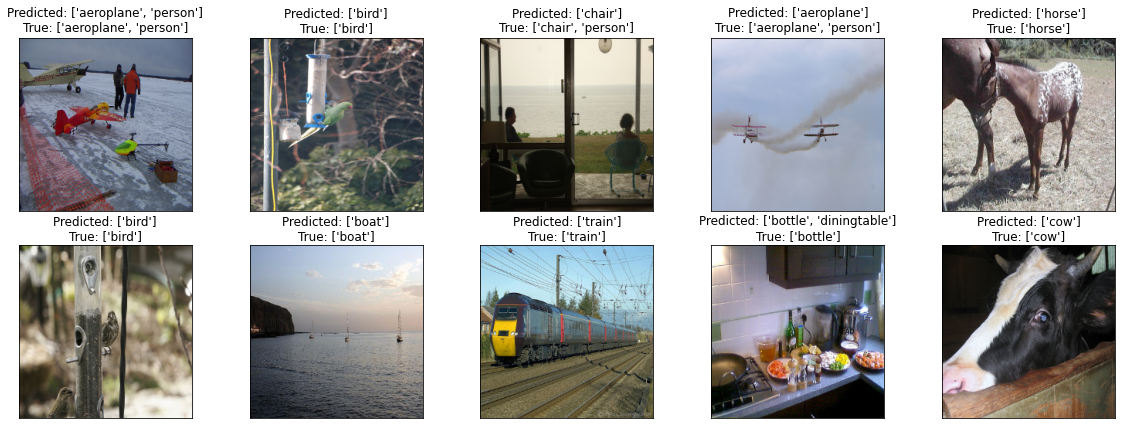

In [18]:
fig=plt.figure(figsize=(20, 7))
for i in range(1,6):
  idx = random.randint(0,len(x_train))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_train[idx]+1)/2)
  y_pred = one_hot_decode(np.around(model(x_train[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_train[idx])))
  plt.xticks([])
  plt.yticks([])
for i in range(6,11):
  idx = random.randint(0,len(x_val))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_val[idx]+1)/2)
  y_pred = one_hot_decode(np.around(model(x_val[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_val[idx])))
  plt.xticks([])
  plt.yticks([])

In [0]:
base_model.trainable = True
for layer in base_model.layers[:100]:
  layer.trainable =  False

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR/10), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[MacroF1(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TopKCategoricalAccuracy(k=1)])

In [21]:
epochCount = 15
history = model.fit(train_batches,
                    epochs=epochCount,
                    validation_data=validation_batches)

Epoch 1/15
35/35 [==============================] - 167s 5s/step - loss: 0.0743 - macro_f1: 0.8098 - true_positives_1: 3879.0000 - true_negatives_1: 63725.0000 - false_positives_1: 407.0000 - false_negatives_1: 1449.0000 - top_k_categorical_accuracy: 0.7020 - val_loss: 0.0889 - val_macro_f1: 0.7667 - val_true_positives_1: 4007.0000 - val_true_negatives_1: 65461.0000 - val_false_positives_1: 775.0000 - val_false_negatives_1: 1377.0000 - val_top_k_categorical_accuracy: 0.7143
Epoch 2/15
35/35 [==============================] - 168s 5s/step - loss: 0.0629 - macro_f1: 0.8477 - true_positives_1: 4137.0000 - true_negatives_1: 63807.0000 - false_positives_1: 325.0000 - false_negatives_1: 1191.0000 - top_k_categorical_accuracy: 0.7360 - val_loss: 0.0886 - val_macro_f1: 0.7669 - val_true_positives_1: 3995.0000 - val_true_negatives_1: 65485.0000 - val_false_positives_1: 751.0000 - val_false_negatives_1: 1389.0000 - val_top_k_categorical_accuracy: 0.7146
Epoch 3/15
35/35 [========================

* categorical_accuracy: the node with the highest output should also be a detected label
* sigmoid_cross_entropy_with_logits

In [22]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [23]:
m = tf.keras.metrics.CategoricalAccuracy() 
_ = m.update_state([[0,0,1,0],[0, 1, 0, 0]], [[0,0.1,0.1,0.2],[0, 1, 0, 0]]) 
m.result().numpy() 

0.5

In [24]:
m = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
_ = m.update_state([[0,0,1,1],[0, 1, 0, 0]], [[0,0.6,0.5,0.2],[0, 1, 0, 0]]) 
m.result().numpy() 

0.5

In [25]:
print(x_val[0:1].shape)

(1, 224, 224, 3)


In [26]:
y_pred = model(x_val[0:1])
y_pred = np.around(y_pred).astype('int')
print(y_pred)
print(one_hot_decode(y_pred[0]))
print(one_hot_decode(y_val[0]))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[]
['tvmonitor']


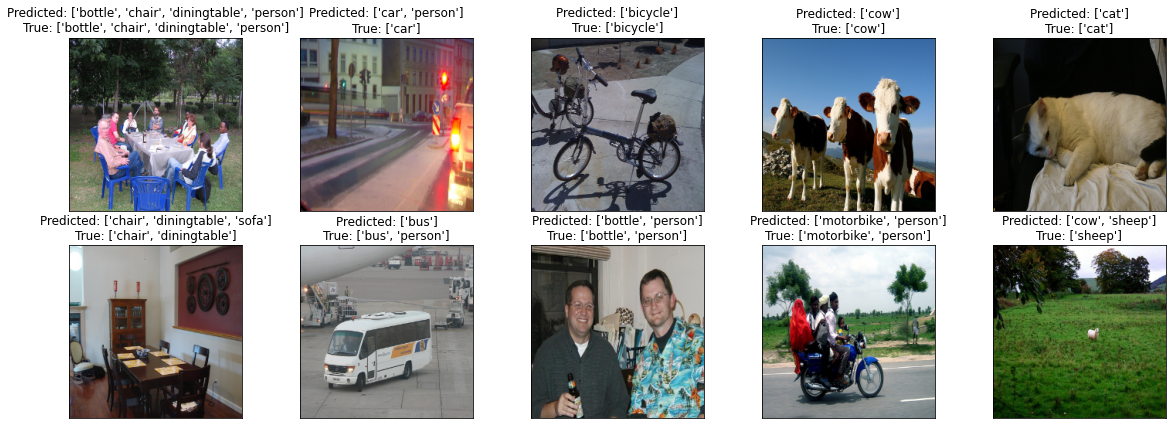

In [27]:
fig=plt.figure(figsize=(20, 7))
for i in range(1,6):
  idx = random.randint(0,len(x_train))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_train[idx]+1)/2)
  y_pred = one_hot_decode(np.around(model(x_train[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_train[idx])))
  plt.xticks([])
  plt.yticks([])
for i in range(6,11):
  idx = random.randint(0,len(x_val))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_val[idx]+1)/2)
  y_pred = one_hot_decode(np.around(model(x_val[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_val[idx])))
  plt.xticks([])
  plt.yticks([])

Some confusion occurs in the algorithm because we are doing multilabel classification instead of detection. The algorithm seems to get confused sometimes because it does not always find the exact area in the picture to which the label belongs. Tipical cases are predicting a person and a bike, when only a bike is visible in the picture, probably because in most pictures these occur together, which might confuse the alogritm. Similarly, a bottle seems to be hard to predict. Probably, because this mostly is a small part of a picture, surrounded by different other objects.